In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math

2023-10-07 09:00:00.580787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import numpy as np
from tensorflow import keras

# Load the CIFAR-10 dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Convert the images to float32 and normalize them to the range [0, 1]
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# Split the training set into training and validation sets
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# Convert images to grayscale
X_train_gray = np.dot(X_train, [0.2989, 0.5870, 0.1140])
X_valid_gray = np.dot(X_valid, [0.2989, 0.5870, 0.1140])
X_test_gray = np.dot(X_test, [0.2989, 0.5870, 0.1140])

# Reshape grayscale images to have a single channel
X_train_gray = X_train_gray.reshape(-1, 32, 32, 1)
X_valid_gray = X_valid_gray.reshape(-1, 32, 32, 1)
X_test_gray = X_test_gray.reshape(-1, 32, 32, 1)


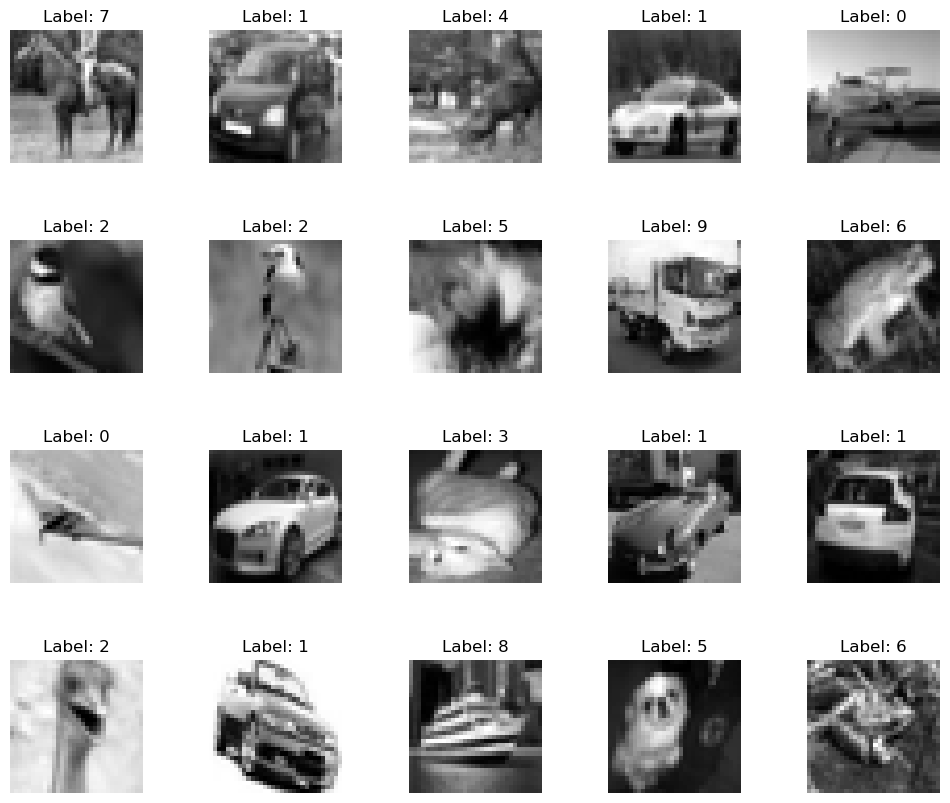

In [3]:
import matplotlib.pyplot as plt

# Define the number of images you want to visualize (top 20)
num_images_to_visualize = 20

# Create a subplot with multiple rows and columns
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 10))

# Flatten the axes array to make it easier to iterate
axes = axes.ravel()

# Loop through the first 20 images in X_valid_gray and display them
for i in range(num_images_to_visualize):
    # Select the i-th image
    image = X_valid_gray[i].squeeze()  # Remove the single-channel dimension
    
    # Set the title of the subplot to the corresponding label from y_valid
    axes[i].set_title(f"Label: {y_valid[i][0]}")
    
    # Display the image in grayscale
    axes[i].imshow(image, cmap='gray')
    
    # Remove axis labels
    axes[i].axis('off')

# Adjust subplot layout for better spacing
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Show the plotted images
plt.show()


In [4]:
class GeneralAE:
    def __init__(self, optimizer = keras.optimizers.SGD(lr=0.1)):
        self.encoder = None
        self.decoder = None
        self.auto_encoder = None
        self.optimizer = optimizer
    
    @staticmethod
    def reconstruction_loss(x_true, x_pred):
        return tf.nn.l2_loss(x_true - x_pred)
    
    def encode(self, X=None):
        return self.encoder.predict(X)
    
    def decode(self, h=None):
        return self.decoder.predict(h)
    
    def reconstruct(self, X=None):
        self.auto_encoder.predict(X)
    
    def show_reconstructions(self, X= None, n_cols = 5):
        reconstructions = self.auto_encoder.predict(X)
        n_images = len(X)
        n_rows = math.ceil(n_images/n_cols)
        fig = plt.figure(figsize=(2*n_cols*1.5, n_rows*1.5))
        plt.axis("off")
        for i in range(n_images):
            plt.subplot(n_rows, 2*n_cols, 2*i+1)
            plt.imshow(X[i], cmap="gray")
            plt.xlabel("real")
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.subplot(n_rows, 2*n_cols, 2*i+2)
            plt.imshow(reconstructions[i], cmap="gray")
            plt.xlabel("reconstruct")
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            
    def build(self):
        pass
    
    def train(self, *args, **kwargs):
        self.auto_encoder.fit(*args, **kwargs)

# Auto Encoder

In [5]:
class StandardAE(GeneralAE):
    def __init__(self, optimizer=keras.optimizers.SGD(lr=0.1)):
        super(StandardAE, self).__init__(optimizer)
    
    def build(self):
        self.encoder = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[32, 32, 1]), 
            keras.layers.Dense(512, activation="selu"),
            keras.layers.Dense(128, activation="selu"),
            keras.layers.Dense(30, activation="sigmoid")
        ])
        
        self.decoder = keras.models.Sequential([
            keras.layers.Dense(128, activation="selu", input_shape=[30]),
            keras.layers.Dense(512, activation="selu"),
            keras.layers.Dense(32 * 32 * 1, activation="sigmoid"), 
            keras.layers.Reshape([32, 32, 1])
        ])
        
        self.auto_encoder = keras.models.Sequential([self.encoder, self.decoder])
        self.auto_encoder.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=[GeneralAE.reconstruction_loss])


In [6]:
standard_ae = StandardAE()
standard_ae.build()
standard_ae.train(X_train_gray, X_train_gray, epochs=100, validation_data=(X_valid_gray, X_valid_gray))

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 0.6955 - reconstruction_loss: 962.8891 - val_loss: 0.6935 - val_reconstruction_loss: 930.4324
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6930 - reconstruction_loss: 942.3319 - val_loss: 0.6925 - val_reconstruction_loss: 922.3456
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6922 - reconstruction_loss: 936.2586 - val_loss: 0.6919 - val_reconstruction_loss: 917.2849
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6916 - reconstruction_loss: 931.1367 - val_loss: 0.6913 - val_reconstruction_loss: 911.9994
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6909 - reconstruction_loss: 925.2416 - val_loss: 0.6905 - val_reconstruction_loss: 905.5153
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6899 - reconstruction_loss: 917.8263 - val_loss: 0.689

1407/1407 [==============================] - 14s 10ms/step - loss: 0.6242 - reconstruction_loss: 417.3027 - val_loss: 0.6248 - val_reconstruction_loss: 407.2269
Epoch 96/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6240 - reconstruction_loss: 416.2568 - val_loss: 0.6247 - val_reconstruction_loss: 406.2343
Epoch 97/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6239 - reconstruction_loss: 415.1995 - val_loss: 0.6245 - val_reconstruction_loss: 405.1790
Epoch 98/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6237 - reconstruction_loss: 414.1441 - val_loss: 0.6244 - val_reconstruction_loss: 404.1988
Epoch 99/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6236 - reconstruction_loss: 413.0784 - val_loss: 0.6242 - val_reconstruction_loss: 403.1841
Epoch 100/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6234 - reconstruction_loss: 412.0118 - val_loss: 0.6241 - va

1/1 [==============================] - 0s 158ms/step


/var/folders/yt/l0nw77zs49ngzv8jdxrtpfbh0000gn/T/ipykernel_17298/926366502.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, 2*n_cols, 2*i+1)


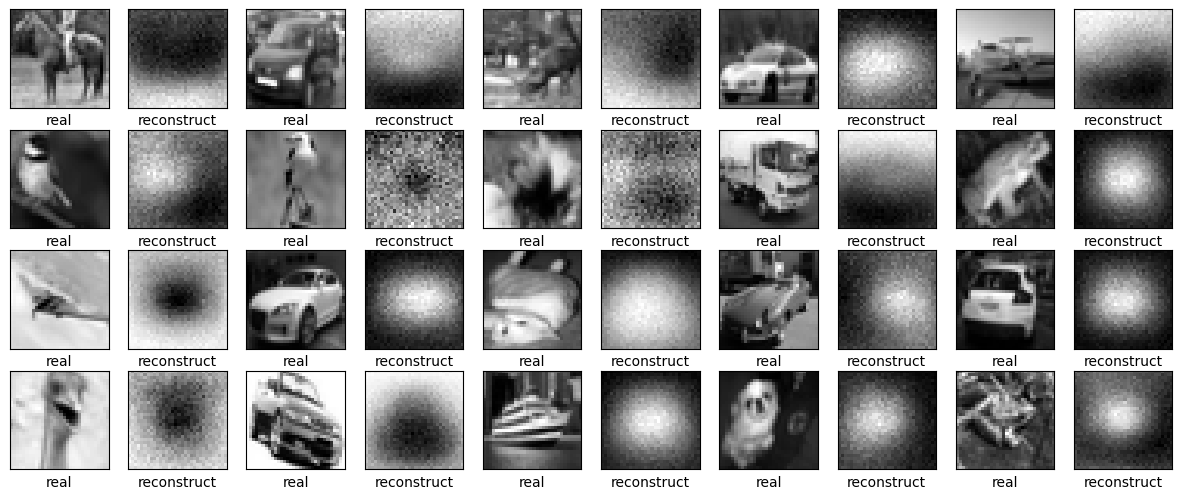

In [7]:
standard_ae.show_reconstructions(X_valid_gray[:20], n_cols=5)

In [8]:
class Conv2D_StandardAE(GeneralAE):
    def __init__(self, optimizer=keras.optimizers.SGD(lr=0.1)):
        super(Conv2D_StandardAE, self).__init__(optimizer)
    
    def build(self):
        self.encoder = keras.models.Sequential([
            keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu", input_shape=[32, 32, 1]), #[32, 32, 32]
            keras.layers.MaxPool2D(pool_size=2), #[16, 16, 32]
            keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"), #[16, 16, 64]
            keras.layers.MaxPool2D(pool_size=2), #[8, 8, 64]
            keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"), #[8, 8, 128]
            keras.layers.MaxPool2D(pool_size=2) #[4, 4, 128]
        ])

        self.decoder = keras.models.Sequential([
            keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, 
                                          padding="SAME", activation="selu", input_shape=[4, 4, 128]), #[8, 8, 64]
            keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="SAME", activation="selu"), #[16, 16, 32]
            keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid")  #[32, 32, 1]
        ])


        self.auto_encoder = keras.models.Sequential([self.encoder, self.decoder])
        self.auto_encoder.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=[GeneralAE.reconstruction_loss])


In [9]:
conv_standard_ae = Conv2D_StandardAE()
conv_standard_ae.build()
conv_standard_ae.train(X_train_gray, X_train_gray, epochs=100, validation_data=(X_valid_gray, X_valid_gray))

Epoch 1/100
1407/1407 [==============================] - 67s 47ms/step - loss: 0.6918 - reconstruction_loss: 933.0468 - val_loss: 0.6901 - val_reconstruction_loss: 902.3137
Epoch 2/100
1407/1407 [==============================] - 66s 47ms/step - loss: 0.6856 - reconstruction_loss: 881.9298 - val_loss: 0.6769 - val_reconstruction_loss: 795.1943
Epoch 3/100
1407/1407 [==============================] - 66s 47ms/step - loss: 0.6496 - reconstruction_loss: 598.1494 - val_loss: 0.6271 - val_reconstruction_loss: 414.4973
Epoch 4/100
1407/1407 [==============================] - 68s 49ms/step - loss: 0.6205 - reconstruction_loss: 382.4475 - val_loss: 0.6173 - val_reconstruction_loss: 346.2455
Epoch 5/100
1407/1407 [==============================] - 71s 50ms/step - loss: 0.6136 - reconstruction_loss: 334.2092 - val_loss: 0.6122 - val_reconstruction_loss: 310.9675
Epoch 6/100
1407/1407 [==============================] - 68s 48ms/step - loss: 0.6092 - reconstruction_loss: 304.1197 - val_loss: 0.608

1407/1407 [==============================] - 67s 48ms/step - loss: 0.5798 - reconstruction_loss: 112.9356 - val_loss: 0.5817 - val_reconstruction_loss: 111.6152
Epoch 96/100
1407/1407 [==============================] - 72s 52ms/step - loss: 0.5797 - reconstruction_loss: 112.5737 - val_loss: 0.5816 - val_reconstruction_loss: 111.0647
Epoch 97/100
1407/1407 [==============================] - 72s 51ms/step - loss: 0.5797 - reconstruction_loss: 112.2206 - val_loss: 0.5815 - val_reconstruction_loss: 110.7234
Epoch 98/100
1407/1407 [==============================] - 69s 49ms/step - loss: 0.5796 - reconstruction_loss: 111.8696 - val_loss: 0.5815 - val_reconstruction_loss: 110.5751
Epoch 99/100
1407/1407 [==============================] - 68s 48ms/step - loss: 0.5796 - reconstruction_loss: 111.5232 - val_loss: 0.5814 - val_reconstruction_loss: 110.0497
Epoch 100/100
1407/1407 [==============================] - 68s 48ms/step - loss: 0.5795 - reconstruction_loss: 111.1818 - val_loss: 0.5814 - va

1/1 [==============================] - 0s 164ms/step


/var/folders/yt/l0nw77zs49ngzv8jdxrtpfbh0000gn/T/ipykernel_17298/926366502.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, 2*n_cols, 2*i+1)


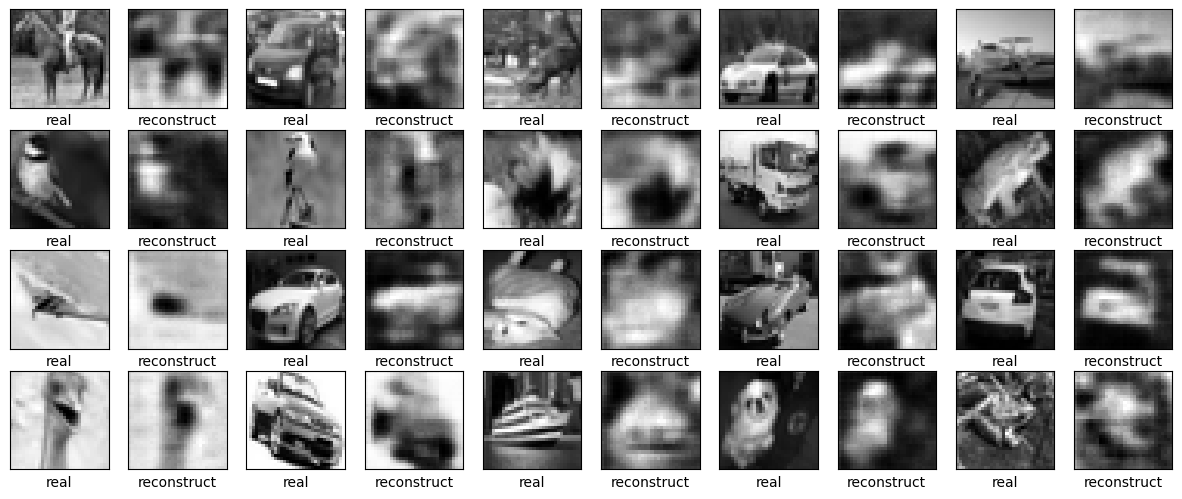

In [10]:
conv_standard_ae.show_reconstructions(X_valid_gray[:20], n_cols=5)

# Sparse AE

In [11]:
class SparseAE(GeneralAE):
    def __init__(self, optimizer=keras.optimizers.SGD(), regularizer=keras.regularizers.l1(l=0.0001)):
        super(SparseAE, self).__init__(optimizer)
        self.regularizer = regularizer
    
    def build(self):
        self.encoder = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[32, 32, 1]), 
            keras.layers.Dense(512, activation="selu"),
            keras.layers.Dense(128, activation="selu"),
            keras.layers.Dense(30, activation="sigmoid", activity_regularizer=self.regularizer)
        ])
        
        self.decoder = keras.models.Sequential([
            keras.layers.Dense(128, activation="selu", input_shape=[30]),
            keras.layers.Dense(512, activation="selu"),
            keras.layers.Dense(32 * 32 * 1, activation="sigmoid"), 
            keras.layers.Reshape([32, 32, 1])
        ])
        
        self.auto_encoder = keras.models.Sequential([self.encoder, self.decoder])
        self.auto_encoder.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=[GeneralAE.reconstruction_loss])


In [12]:
sparse_ae = SparseAE()
sparse_ae.build()
sparse_ae.train(X_train_gray, X_train_gray, epochs=100, validation_data=(X_valid_gray, X_valid_gray))

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 0.6972 - reconstruction_loss: 968.8563 - val_loss: 0.6944 - val_reconstruction_loss: 932.1933
Epoch 2/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6937 - reconstruction_loss: 944.1976 - val_loss: 0.6932 - val_reconstruction_loss: 924.3859
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6929 - reconstruction_loss: 938.9066 - val_loss: 0.6927 - val_reconstruction_loss: 920.5469
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6925 - reconstruction_loss: 935.3901 - val_loss: 0.6923 - val_reconstruction_loss: 917.2599
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6920 - reconstruction_loss: 931.9136 - val_loss: 0.6918 - val_reconstruction_loss: 913.6213
Epoch 6/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6916 - reconstruction_loss: 927.8112 - val_loss: 0.691

1407/1407 [==============================] - 14s 10ms/step - loss: 0.6275 - reconstruction_loss: 437.2472 - val_loss: 0.6281 - val_reconstruction_loss: 426.6147
Epoch 96/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6274 - reconstruction_loss: 436.3124 - val_loss: 0.6280 - val_reconstruction_loss: 425.7312
Epoch 97/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6273 - reconstruction_loss: 435.3920 - val_loss: 0.6279 - val_reconstruction_loss: 424.8098
Epoch 98/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6272 - reconstruction_loss: 434.4899 - val_loss: 0.6277 - val_reconstruction_loss: 423.9698
Epoch 99/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6270 - reconstruction_loss: 433.6037 - val_loss: 0.6276 - val_reconstruction_loss: 423.1012
Epoch 100/100
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6269 - reconstruction_loss: 432.7319 - val_loss: 0.6275 - va

1/1 [==============================] - 0s 110ms/step


/var/folders/yt/l0nw77zs49ngzv8jdxrtpfbh0000gn/T/ipykernel_17298/926366502.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, 2*n_cols, 2*i+1)


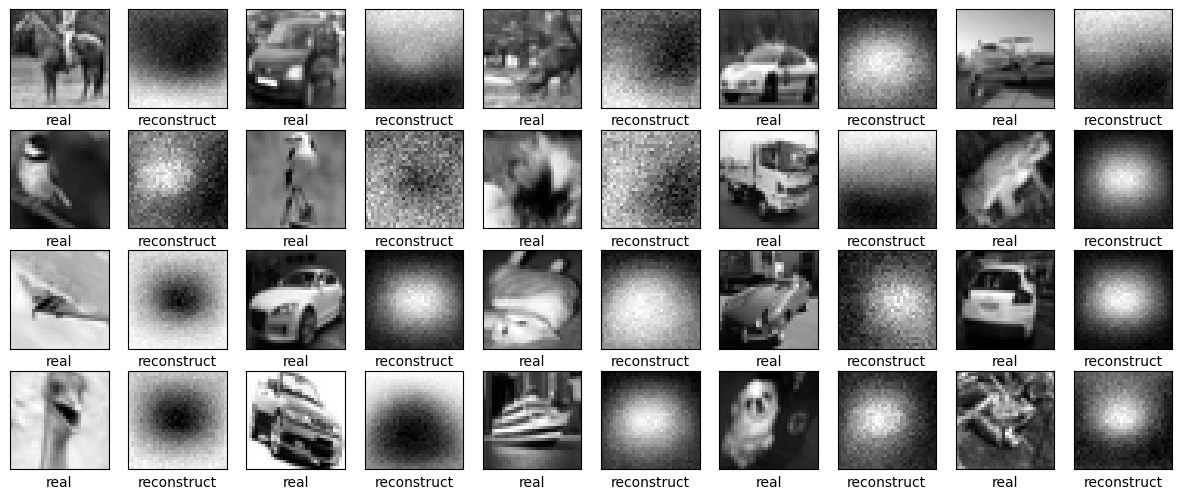

In [13]:
sparse_ae.show_reconstructions(X_valid_gray[:20], n_cols=5)

In [14]:
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, l, target=0.1):
        self.weight = l
        self.target = target
    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities))

In [16]:
kl_sparse_ae = SparseAE(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.1), regularizer=KLDivergenceRegularizer(l=0.01))
kl_sparse_ae.build()
kl_sparse_ae.train(X_train_gray, X_train_gray, epochs=200, validation_data=(X_valid_gray, X_valid_gray))

Epoch 1/200
1407/1407 [==============================] - 15s 10ms/step - loss: 0.6924 - reconstruction_loss: 935.6940 - val_loss: 0.6897 - val_reconstruction_loss: 897.7691
Epoch 2/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6818 - reconstruction_loss: 848.1412 - val_loss: 0.6707 - val_reconstruction_loss: 742.2418
Epoch 3/200
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6587 - reconstruction_loss: 666.2645 - val_loss: 0.6496 - val_reconstruction_loss: 583.0605
Epoch 4/200
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6448 - reconstruction_loss: 563.9043 - val_loss: 0.6425 - val_reconstruction_loss: 532.7172
Epoch 5/200
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6400 - reconstruction_loss: 529.6610 - val_loss: 0.6388 - val_reconstruction_loss: 505.6490
Epoch 6/200
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6362 - reconstruction_loss: 501.0080 - val_loss: 0.635

1407/1407 [==============================] - 16s 11ms/step - loss: 0.6015 - reconstruction_loss: 256.4194 - val_loss: 0.6031 - val_reconstruction_loss: 254.0363
Epoch 96/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6014 - reconstruction_loss: 255.8370 - val_loss: 0.6028 - val_reconstruction_loss: 251.7689
Epoch 97/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6013 - reconstruction_loss: 255.2091 - val_loss: 0.6029 - val_reconstruction_loss: 252.0417
Epoch 98/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6012 - reconstruction_loss: 254.6340 - val_loss: 0.6028 - val_reconstruction_loss: 251.2760
Epoch 99/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6011 - reconstruction_loss: 254.0081 - val_loss: 0.6026 - val_reconstruction_loss: 250.1094
Epoch 100/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6010 - reconstruction_loss: 253.4677 - val_loss: 0.6024 - va

Epoch 142/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5987 - reconstruction_loss: 238.2461 - val_loss: 0.6004 - val_reconstruction_loss: 235.4983
Epoch 143/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5987 - reconstruction_loss: 237.9728 - val_loss: 0.6002 - val_reconstruction_loss: 234.1048
Epoch 144/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5986 - reconstruction_loss: 237.6784 - val_loss: 0.6002 - val_reconstruction_loss: 234.0823
Epoch 145/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5986 - reconstruction_loss: 237.3951 - val_loss: 0.6001 - val_reconstruction_loss: 233.6279
Epoch 146/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5985 - reconstruction_loss: 237.0782 - val_loss: 0.6003 - val_reconstruction_loss: 235.4454
Epoch 147/200
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5985 - reconstruction_loss: 236.7734 - val

Epoch 189/200
1407/1407 [==============================] - 14s 10ms/step - loss: 0.5972 - reconstruction_loss: 228.7981 - val_loss: 0.5989 - val_reconstruction_loss: 225.7851
Epoch 190/200
1407/1407 [==============================] - 14s 10ms/step - loss: 0.5972 - reconstruction_loss: 228.6284 - val_loss: 0.5990 - val_reconstruction_loss: 226.9382
Epoch 191/200
1407/1407 [==============================] - 14s 10ms/step - loss: 0.5972 - reconstruction_loss: 228.4150 - val_loss: 0.5989 - val_reconstruction_loss: 225.6265
Epoch 192/200
1407/1407 [==============================] - 14s 10ms/step - loss: 0.5972 - reconstruction_loss: 228.1760 - val_loss: 0.5989 - val_reconstruction_loss: 225.9836
Epoch 193/200
1407/1407 [==============================] - 14s 10ms/step - loss: 0.5971 - reconstruction_loss: 227.9995 - val_loss: 0.5991 - val_reconstruction_loss: 227.3689
Epoch 194/200
1407/1407 [==============================] - 14s 10ms/step - loss: 0.5971 - reconstruction_loss: 227.7661 - val

1/1 [==============================] - 0s 130ms/step


/var/folders/yt/l0nw77zs49ngzv8jdxrtpfbh0000gn/T/ipykernel_17298/926366502.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, 2*n_cols, 2*i+1)


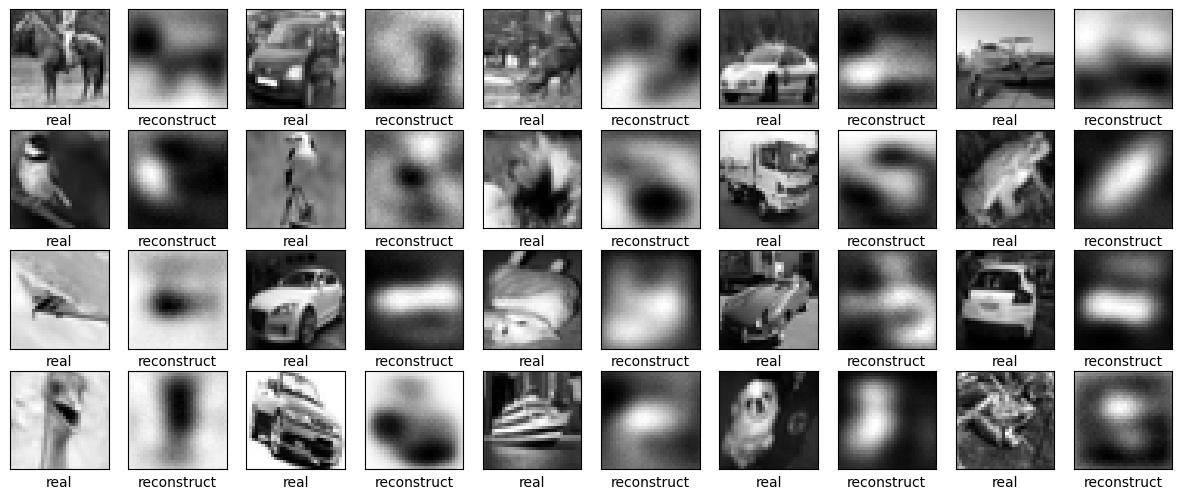

In [19]:
kl_sparse_ae.show_reconstructions(X_valid_gray[:20], n_cols=5)

# Denoising AE

In [22]:
class DenoisingAE(GeneralAE):
    def __init__(self, optimizer=keras.optimizers.SGD(lr=0.1), noise=0.2, seed=6789):
        super(DenoisingAE, self).__init__(optimizer)
        self.noise = noise
        self.seed = seed
        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)
    
    def build(self):
        self.encoder = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[32, 32, 1]),  
            keras.layers.GaussianNoise(self.noise),
            keras.layers.Dense(512, activation="selu"),  
            keras.layers.Dense(128, activation="selu"),  
            keras.layers.Dense(30, activation="selu")
        ])
        
        self.decoder = keras.models.Sequential([
            keras.layers.Dense(128, activation="selu", input_shape=[30]),  
            keras.layers.Dense(512, activation="selu"),  
            keras.layers.Dense(32 * 32 * 1, activation="sigmoid"), 
            keras.layers.Reshape([32, 32, 1])  
        ])
        
        self.auto_encoder = keras.models.Sequential([self.encoder, self.decoder])
        self.auto_encoder.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=[GeneralAE.reconstruction_loss])


In [23]:
denoising_ae = DenoisingAE()
denoising_ae.build()
denoising_ae.train(X_train_gray, X_train_gray, epochs=500, validation_data=(X_valid_gray, X_valid_gray))

Epoch 1/500
1407/1407 [==============================] - 15s 10ms/step - loss: 0.7026 - reconstruction_loss: 1018.1296 - val_loss: 0.6949 - val_reconstruction_loss: 940.8652
Epoch 2/500
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6963 - reconstruction_loss: 968.0415 - val_loss: 0.6891 - val_reconstruction_loss: 894.5358
Epoch 3/500
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6889 - reconstruction_loss: 909.4998 - val_loss: 0.6809 - val_reconstruction_loss: 828.7461
Epoch 4/500
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6794 - reconstruction_loss: 833.8226 - val_loss: 0.6711 - val_reconstruction_loss: 752.4670
Epoch 5/500
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6694 - reconstruction_loss: 755.5359 - val_loss: 0.6620 - val_reconstruction_loss: 682.3361
Epoch 6/500
1407/1407 [==============================] - 14s 10ms/step - loss: 0.6609 - reconstruction_loss: 689.5922 - val_loss: 0.65

1407/1407 [==============================] - 15s 11ms/step - loss: 0.6096 - reconstruction_loss: 312.6432 - val_loss: 0.6089 - val_reconstruction_loss: 293.2433
Epoch 96/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.6095 - reconstruction_loss: 311.5685 - val_loss: 0.6088 - val_reconstruction_loss: 292.3857
Epoch 97/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.6093 - reconstruction_loss: 310.5009 - val_loss: 0.6086 - val_reconstruction_loss: 291.1776
Epoch 98/500
1407/1407 [==============================] - 15s 10ms/step - loss: 0.6092 - reconstruction_loss: 309.5133 - val_loss: 0.6085 - val_reconstruction_loss: 290.2263
Epoch 99/500
1407/1407 [==============================] - 15s 10ms/step - loss: 0.6090 - reconstruction_loss: 308.3767 - val_loss: 0.6083 - val_reconstruction_loss: 289.0829
Epoch 100/500
1407/1407 [==============================] - 15s 10ms/step - loss: 0.6089 - reconstruction_loss: 307.3383 - val_loss: 0.6082 - va

Epoch 142/500
1407/1407 [==============================] - 15s 10ms/step - loss: 0.6039 - reconstruction_loss: 273.5676 - val_loss: 0.6032 - val_reconstruction_loss: 254.6689
Epoch 143/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.6038 - reconstruction_loss: 272.9572 - val_loss: 0.6032 - val_reconstruction_loss: 254.0897
Epoch 144/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6037 - reconstruction_loss: 272.3539 - val_loss: 0.6031 - val_reconstruction_loss: 253.3986
Epoch 145/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6036 - reconstruction_loss: 271.7825 - val_loss: 0.6030 - val_reconstruction_loss: 252.8900
Epoch 146/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6035 - reconstruction_loss: 271.2572 - val_loss: 0.6029 - val_reconstruction_loss: 252.2731
Epoch 147/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6034 - reconstruction_loss: 270.7538 - val

Epoch 189/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.6008 - reconstruction_loss: 252.8851 - val_loss: 0.6002 - val_reconstruction_loss: 234.0835
Epoch 190/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.6007 - reconstruction_loss: 252.4961 - val_loss: 0.6002 - val_reconstruction_loss: 234.1891
Epoch 191/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.6007 - reconstruction_loss: 252.1786 - val_loss: 0.6002 - val_reconstruction_loss: 233.9590
Epoch 192/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.6006 - reconstruction_loss: 251.9221 - val_loss: 0.6000 - val_reconstruction_loss: 233.1035
Epoch 193/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6006 - reconstruction_loss: 251.5448 - val_loss: 0.6000 - val_reconstruction_loss: 233.0885
Epoch 194/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.6005 - reconstruction_loss: 251.1950 - val

Epoch 236/500
1407/1407 [==============================] - 18s 13ms/step - loss: 0.5990 - reconstruction_loss: 240.6656 - val_loss: 0.5984 - val_reconstruction_loss: 222.0702
Epoch 237/500
1407/1407 [==============================] - 18s 13ms/step - loss: 0.5990 - reconstruction_loss: 240.4231 - val_loss: 0.5983 - val_reconstruction_loss: 221.6886
Epoch 238/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5989 - reconstruction_loss: 240.2176 - val_loss: 0.5983 - val_reconstruction_loss: 221.5316
Epoch 239/500
1407/1407 [==============================] - 24s 17ms/step - loss: 0.5989 - reconstruction_loss: 239.9894 - val_loss: 0.5983 - val_reconstruction_loss: 221.3258
Epoch 240/500
1407/1407 [==============================] - 26s 18ms/step - loss: 0.5989 - reconstruction_loss: 239.7944 - val_loss: 0.5983 - val_reconstruction_loss: 221.4884
Epoch 241/500
1407/1407 [==============================] - 25s 18ms/step - loss: 0.5988 - reconstruction_loss: 239.5981 - val

Epoch 283/500
1407/1407 [==============================] - 26s 19ms/step - loss: 0.5978 - reconstruction_loss: 232.4618 - val_loss: 0.5972 - val_reconstruction_loss: 213.8965
Epoch 284/500
1407/1407 [==============================] - 28s 20ms/step - loss: 0.5978 - reconstruction_loss: 232.3002 - val_loss: 0.5972 - val_reconstruction_loss: 213.8792
Epoch 285/500
1407/1407 [==============================] - 27s 19ms/step - loss: 0.5977 - reconstruction_loss: 232.1505 - val_loss: 0.5971 - val_reconstruction_loss: 213.5906
Epoch 286/500
1407/1407 [==============================] - 25s 18ms/step - loss: 0.5977 - reconstruction_loss: 232.0647 - val_loss: 0.5971 - val_reconstruction_loss: 213.4406
Epoch 287/500
1407/1407 [==============================] - 29s 21ms/step - loss: 0.5977 - reconstruction_loss: 231.8482 - val_loss: 0.5971 - val_reconstruction_loss: 213.4182
Epoch 288/500
1407/1407 [==============================] - 27s 19ms/step - loss: 0.5977 - reconstruction_loss: 231.7523 - val

Epoch 330/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5968 - reconstruction_loss: 225.8292 - val_loss: 0.5962 - val_reconstruction_loss: 207.2703
Epoch 331/500
1407/1407 [==============================] - 19s 13ms/step - loss: 0.5968 - reconstruction_loss: 225.7404 - val_loss: 0.5962 - val_reconstruction_loss: 207.0768
Epoch 332/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5968 - reconstruction_loss: 225.6363 - val_loss: 0.5962 - val_reconstruction_loss: 206.9556
Epoch 333/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5968 - reconstruction_loss: 225.4956 - val_loss: 0.5962 - val_reconstruction_loss: 206.8390
Epoch 334/500
1407/1407 [==============================] - 16s 12ms/step - loss: 0.5968 - reconstruction_loss: 225.3626 - val_loss: 0.5962 - val_reconstruction_loss: 206.8023
Epoch 335/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5967 - reconstruction_loss: 225.2222 - val

Epoch 377/500
1407/1407 [==============================] - 20s 15ms/step - loss: 0.5960 - reconstruction_loss: 220.1698 - val_loss: 0.5954 - val_reconstruction_loss: 201.7085
Epoch 378/500
1407/1407 [==============================] - 18s 13ms/step - loss: 0.5960 - reconstruction_loss: 220.0692 - val_loss: 0.5953 - val_reconstruction_loss: 201.3898
Epoch 379/500
1407/1407 [==============================] - 15s 11ms/step - loss: 0.5960 - reconstruction_loss: 219.9252 - val_loss: 0.5954 - val_reconstruction_loss: 201.3834
Epoch 380/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5959 - reconstruction_loss: 219.8116 - val_loss: 0.5955 - val_reconstruction_loss: 201.8472
Epoch 381/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5959 - reconstruction_loss: 219.7705 - val_loss: 0.5953 - val_reconstruction_loss: 200.9466
Epoch 382/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5959 - reconstruction_loss: 219.6284 - val

Epoch 424/500
1407/1407 [==============================] - 16s 12ms/step - loss: 0.5953 - reconstruction_loss: 215.5453 - val_loss: 0.5948 - val_reconstruction_loss: 197.2095
Epoch 425/500
1407/1407 [==============================] - 19s 14ms/step - loss: 0.5953 - reconstruction_loss: 215.4836 - val_loss: 0.5947 - val_reconstruction_loss: 196.9098
Epoch 426/500
1407/1407 [==============================] - 20s 14ms/step - loss: 0.5953 - reconstruction_loss: 215.3702 - val_loss: 0.5947 - val_reconstruction_loss: 196.7027
Epoch 427/500
1407/1407 [==============================] - 25s 18ms/step - loss: 0.5953 - reconstruction_loss: 215.3095 - val_loss: 0.5947 - val_reconstruction_loss: 196.8680
Epoch 428/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5953 - reconstruction_loss: 215.2532 - val_loss: 0.5946 - val_reconstruction_loss: 196.5259
Epoch 429/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5953 - reconstruction_loss: 215.1618 - val

Epoch 471/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5948 - reconstruction_loss: 211.9106 - val_loss: 0.5942 - val_reconstruction_loss: 193.1761
Epoch 472/500
1407/1407 [==============================] - 17s 12ms/step - loss: 0.5948 - reconstruction_loss: 211.7929 - val_loss: 0.5941 - val_reconstruction_loss: 192.9932
Epoch 473/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5948 - reconstruction_loss: 211.7839 - val_loss: 0.5942 - val_reconstruction_loss: 193.0991
Epoch 474/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5948 - reconstruction_loss: 211.6985 - val_loss: 0.5942 - val_reconstruction_loss: 193.0907
Epoch 475/500
1407/1407 [==============================] - 16s 11ms/step - loss: 0.5947 - reconstruction_loss: 211.6383 - val_loss: 0.5941 - val_reconstruction_loss: 192.7452
Epoch 476/500
1407/1407 [==============================] - 16s 12ms/step - loss: 0.5947 - reconstruction_loss: 211.4996 - val

1/1 [==============================] - 0s 143ms/step


/var/folders/yt/l0nw77zs49ngzv8jdxrtpfbh0000gn/T/ipykernel_17298/926366502.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, 2*n_cols, 2*i+1)


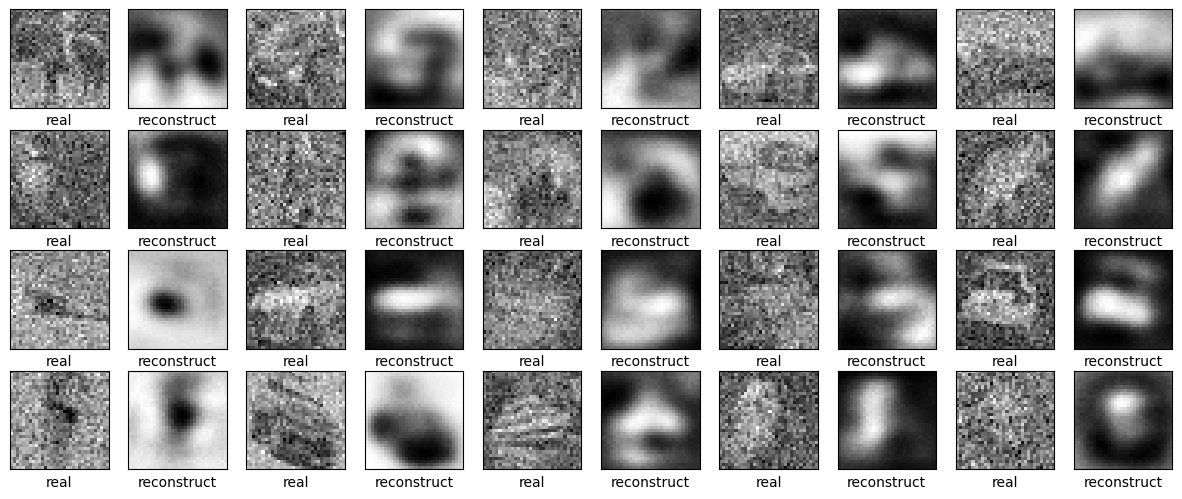

In [24]:
noise = keras.layers.GaussianNoise(0.2)
denoising_ae.show_reconstructions(noise(X_valid_gray[0:20], training=True), n_cols=5)

# Variational Autoencoder

$$ z = \epsilon \odot \exp\left(\frac{\log(\sigma^2)}{2}\right) + \mu $$

$$ KL = -\alpha \times \sum \left( 1 + \log(\sigma^2) - e^{\log(\sigma^2)} - \mu^2 \right) $$


In [30]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.random.normal(tf.shape(log_var)) * tf.math.exp(log_var / 2) + mean 

class VariationalAE(GeneralAE):
    def __init__(self, optimizer=keras.optimizers.SGD(lr=0.1), alpha=0.5, seed=6789):
        super(VariationalAE, self).__init__(optimizer)
        self.alpha = alpha
        self.seed = seed
        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)
    
    def build(self):
        codings_size = 10
        inputs = keras.layers.Input(shape=[32, 32, 1])
        z = keras.layers.Flatten()(inputs)
        z = keras.layers.Dense(512, activation="selu")(z)  
        z = keras.layers.Dense(128, activation="selu")(z)
        codings_mean = keras.layers.Dense(codings_size)(z)
        codings_log_var = keras.layers.Dense(codings_size)(z)
        codings = Sampling()([codings_mean, codings_log_var])
        self.encoder = keras.models.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

        decoder_inputs = keras.layers.Input(shape=[codings_size])
        x = keras.layers.Dense(128, activation="selu")(decoder_inputs)
        x = keras.layers.Dense(512, activation="selu")(x)
        x = keras.layers.Dense(32 * 32 * 1, activation="sigmoid")(x)
        outputs = keras.layers.Reshape([32, 32, 1])(x)
        self.decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])
        
        _, _, codings = self.encoder(inputs)
        reconstructions = self.decoder(codings)
        self.auto_encoder = keras.models.Model(inputs=[inputs], outputs=[reconstructions])
        
        latent_loss = -self.alpha * tf.reduce_sum(1 + codings_log_var - tf.math.exp(codings_log_var) - tf.math.square(codings_mean), axis=-1)
        self.auto_encoder.add_loss(tf.math.reduce_mean(latent_loss) / (32 * 32))
        self.auto_encoder.compile(loss="binary_crossentropy", optimizer=self.optimizer, metrics=[GeneralAE.reconstruction_loss])


In [31]:
vae = VariationalAE()
vae.build()
vae.train(X_train_gray, X_train_gray, epochs=300, validation_data=(X_valid_gray, X_valid_gray))

Epoch 1/300
1407/1407 [==============================] - 20s 14ms/step - loss: 0.7022 - reconstruction_loss: 989.3891 - val_loss: 0.7004 - val_reconstruction_loss: 959.5710
Epoch 2/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6996 - reconstruction_loss: 969.6636 - val_loss: 0.6986 - val_reconstruction_loss: 945.2181
Epoch 3/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6972 - reconstruction_loss: 950.6443 - val_loss: 0.6958 - val_reconstruction_loss: 921.4658
Epoch 4/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6935 - reconstruction_loss: 917.5945 - val_loss: 0.6910 - val_reconstruction_loss: 878.8229
Epoch 5/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6877 - reconstruction_loss: 866.2659 - val_loss: 0.6844 - val_reconstruction_loss: 820.2765
Epoch 6/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6807 - reconstruction_loss: 804.3140 - val_loss: 0.677

1407/1407 [==============================] - 18s 13ms/step - loss: 0.6298 - reconstruction_loss: 381.9648 - val_loss: 0.6309 - val_reconstruction_loss: 375.4597
Epoch 96/300
1407/1407 [==============================] - 20s 14ms/step - loss: 0.6297 - reconstruction_loss: 381.1344 - val_loss: 0.6307 - val_reconstruction_loss: 374.2362
Epoch 97/300
1407/1407 [==============================] - 19s 13ms/step - loss: 0.6296 - reconstruction_loss: 380.2951 - val_loss: 0.6307 - val_reconstruction_loss: 374.4286
Epoch 98/300
1407/1407 [==============================] - 22s 16ms/step - loss: 0.6295 - reconstruction_loss: 379.5247 - val_loss: 0.6305 - val_reconstruction_loss: 373.2131
Epoch 99/300
1407/1407 [==============================] - 32s 22ms/step - loss: 0.6294 - reconstruction_loss: 378.7255 - val_loss: 0.6304 - val_reconstruction_loss: 372.0938
Epoch 100/300
1407/1407 [==============================] - 31s 22ms/step - loss: 0.6293 - reconstruction_loss: 377.9787 - val_loss: 0.6305 - va

Epoch 142/300
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6271 - reconstruction_loss: 360.0019 - val_loss: 0.6285 - val_reconstruction_loss: 356.1785
Epoch 143/300
1407/1407 [==============================] - 19s 13ms/step - loss: 0.6271 - reconstruction_loss: 359.7615 - val_loss: 0.6282 - val_reconstruction_loss: 353.6144
Epoch 144/300
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6271 - reconstruction_loss: 359.5437 - val_loss: 0.6282 - val_reconstruction_loss: 353.8348
Epoch 145/300
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6270 - reconstruction_loss: 359.2378 - val_loss: 0.6281 - val_reconstruction_loss: 353.1870
Epoch 146/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6270 - reconstruction_loss: 359.1118 - val_loss: 0.6281 - val_reconstruction_loss: 352.7223
Epoch 147/300
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6270 - reconstruction_loss: 358.8612 - val

Epoch 189/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6260 - reconstruction_loss: 350.2716 - val_loss: 0.6271 - val_reconstruction_loss: 344.2369
Epoch 190/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6260 - reconstruction_loss: 350.0846 - val_loss: 0.6272 - val_reconstruction_loss: 344.2715
Epoch 191/300
1407/1407 [==============================] - 19s 13ms/step - loss: 0.6260 - reconstruction_loss: 349.8342 - val_loss: 0.6271 - val_reconstruction_loss: 343.8329
Epoch 192/300
1407/1407 [==============================] - 19s 14ms/step - loss: 0.6260 - reconstruction_loss: 349.7191 - val_loss: 0.6271 - val_reconstruction_loss: 343.6640
Epoch 193/300
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6259 - reconstruction_loss: 349.5390 - val_loss: 0.6271 - val_reconstruction_loss: 343.5200
Epoch 194/300
1407/1407 [==============================] - 18s 13ms/step - loss: 0.6259 - reconstruction_loss: 349.2536 - val

Epoch 236/300
1407/1407 [==============================] - 16s 12ms/step - loss: 0.6253 - reconstruction_loss: 343.5459 - val_loss: 0.6265 - val_reconstruction_loss: 338.4863
Epoch 237/300
1407/1407 [==============================] - 16s 12ms/step - loss: 0.6253 - reconstruction_loss: 343.4908 - val_loss: 0.6266 - val_reconstruction_loss: 338.6154
Epoch 238/300
1407/1407 [==============================] - 16s 12ms/step - loss: 0.6253 - reconstruction_loss: 343.4386 - val_loss: 0.6264 - val_reconstruction_loss: 337.0218
Epoch 239/300
1407/1407 [==============================] - 17s 12ms/step - loss: 0.6253 - reconstruction_loss: 343.3053 - val_loss: 0.6264 - val_reconstruction_loss: 337.3589
Epoch 240/300
1407/1407 [==============================] - 16s 12ms/step - loss: 0.6253 - reconstruction_loss: 343.1648 - val_loss: 0.6265 - val_reconstruction_loss: 337.6119
Epoch 241/300
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6253 - reconstruction_loss: 343.0674 - val

Epoch 283/300
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6247 - reconstruction_loss: 337.5534 - val_loss: 0.6259 - val_reconstruction_loss: 331.7862
Epoch 284/300
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6247 - reconstruction_loss: 337.3943 - val_loss: 0.6259 - val_reconstruction_loss: 331.7252
Epoch 285/300
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6247 - reconstruction_loss: 337.2936 - val_loss: 0.6259 - val_reconstruction_loss: 331.8270
Epoch 286/300
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6247 - reconstruction_loss: 337.1747 - val_loss: 0.6261 - val_reconstruction_loss: 333.4054
Epoch 287/300
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6247 - reconstruction_loss: 337.1828 - val_loss: 0.6259 - val_reconstruction_loss: 331.7051
Epoch 288/300
1407/1407 [==============================] - 16s 11ms/step - loss: 0.6247 - reconstruction_loss: 337.0478 - val

1/1 [==============================] - 0s 192ms/step


/var/folders/yt/l0nw77zs49ngzv8jdxrtpfbh0000gn/T/ipykernel_17298/926366502.py:28: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(n_rows, 2*n_cols, 2*i+1)


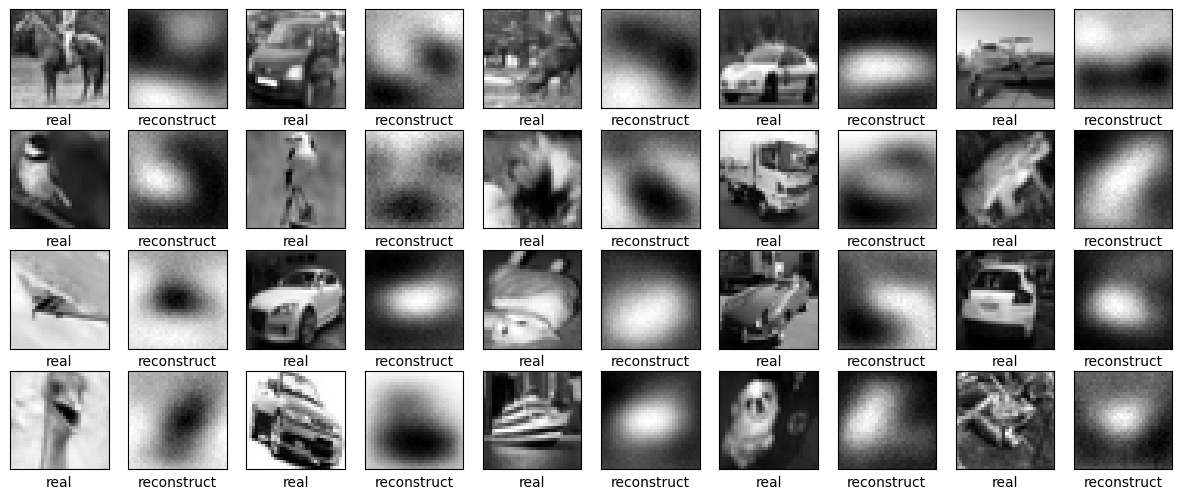

In [32]:
vae.show_reconstructions(X_valid_gray[:20], n_cols=5)

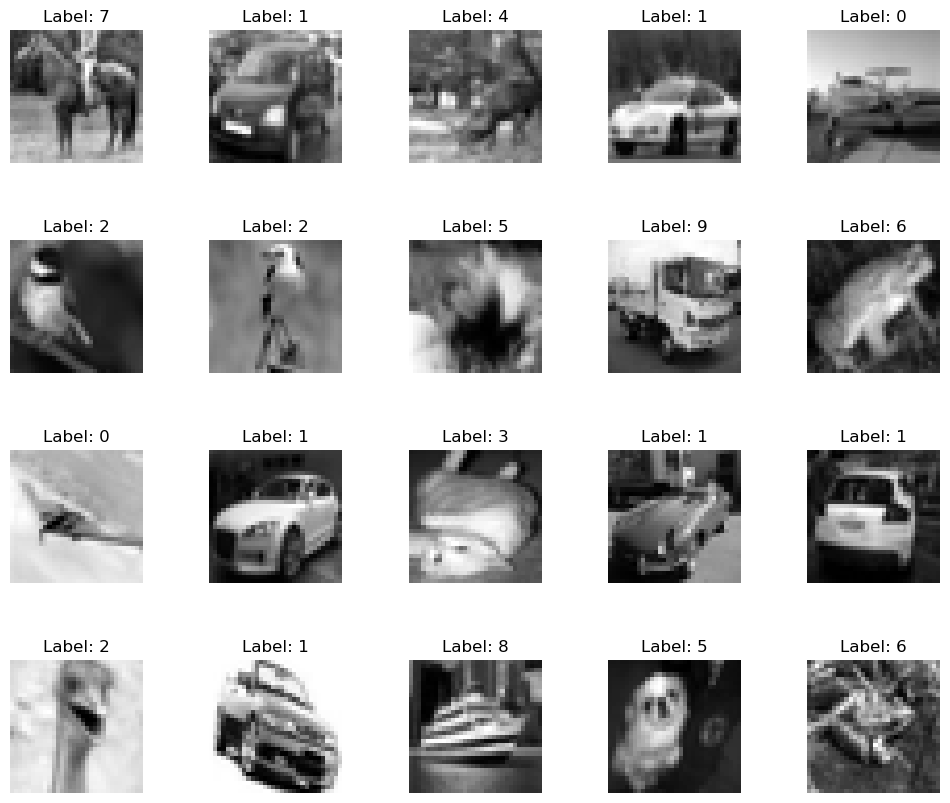